In [1]:
from solve_rg_eqs import solve_Gs_list, G_to_g, unpack_dims, bootstrap_g0
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

# New run

## Setup
First, let's set physical parameters.

In [2]:
l = 6
L = 2*l
N = l
Ne = N//2
if N <= 2*l: # below half-filling
    Nws = np.arange(0, Ne+1, 1) # Not going to check Nw > Ne because that's for Sz > 0
else:
    # above half filling
    # Can fit at most L spin down fermions, L spin up
    # Nw = Ne + Sz = Ne + .5(Nup - Ndown)
    # max(Ndown) = 2*L
    # min(Sz) = .5((N-L) - L) = .5*(N - 4*L)
    min_Nw = Ne + (N-4*l)//2
    Nws = np.arange(min_Nw, Ne+1, 1)
print(Nws)
k = np.arange(1, 2*l+1, 2)*0.5*np.pi/l
Grs = np.arange(.1, 3.6, .1)
Grs = Grs[Grs != 1]
Gs = Grs/np.sum(k)
print(Gs*np.sum(k))

[0 1 2 3]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9
 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5]


Now, let's set numerical parameters. These can be sensitive.

In [3]:
dg = 0.1/L # step size of g.
g0 = dg/L # initial value of g
imk = dg # scale of the imaginary parts added to k
imv = g0/L # scale of the imaginary parts used in the initial guess

skip=N # it's harder for larger N, so let's make it easy on us

## Solving RG equations
Now, we solve the RG equations for each value of Nw (representing different polarizations).
We can calculate energy with different fields afterwards to find which polarization minimizes energy in each situation.

In [4]:
ki = (-1)**np.arange(l)*imk
kc = np.concatenate((k, ki))
outputs = []
for Nw in Nws:
    dims = (l, Ne, Nw)
    sol = bootstrap_g0(dims, g0, kc, imscale_v=imv)
    outputs += [solve_Gs_list(dims, sol, Gs, k, dg=dg, g0=g0, imscale_k=imk, imscale_v=imv)]

Forming guess with Nei, Nwi 
(2, 0)
Guess vars
[0.26175179+0.00833734j 0.7849698 -0.00833743j]
[]

Now using 4 fermions
Ne, Nw = (2, 0)

Variable guess
[0.26175179+0.00833734j 0.7849698 -0.00833743j]
[]
Error with 4 fermions: 4.263256414560601e-14
1

Now using 6 fermions
Ne, Nw = (3, 0)

Variable guess
[0.26175182+0.0083303j  0.78496829-0.00832418j 1.30780703+0.00834139j]
[]
Error with 6 fermions: 3.633241855519979e-13
Incrementing from 0.0006944444444444445 to 0.15915494309189532
g = 0.009, G/Gc = 0.0784
Removing im(k) at g = 0.009027777777777777
s = 1.0
s = 0.9
s = 0.8
s = 0.7000000000000001
s = 0.6000000000000001
s = 0.5000000000000001
s = 0.40000000000000013
s = 0.30000000000000016
s = 0.20000000000000015
s = 0.10000000000000014
s = 1.3877787807814457e-16
Variables after removing im(k)
[0.26099232-1.19407657e-32j 0.7780248 -1.32889166e-32j
 1.28597196+1.17481727e-32j]
[]
g = 0.0174, G/Gc = 0.1406
g = 0.0257, G/Gc = 0.195
Removing im(k) at g = 0.025694444444444443
s = 1.0
s = 0.9
s 

# Energies with magnetic field

In [5]:
h = 0 # Sanity check
for i, o in enumerate(outputs):
    Sz = Nws[i] - Ne
    print('Total Sz:')
    print(Sz)
    print(o['energy'].iloc[-1] + h * Sz)

Total Sz:
-3
-50.46728171134515
Total Sz:
-2
-50.467281711345144
Total Sz:
-1
-51.4959470888502
Total Sz:
0
-51.4959470888502


In [6]:
h = .5 # so spin-down has lower energy
for i, o in enumerate(outputs):
    Sz = Nws[i] - Ne
    print('Total Sz:')
    print(Sz)
    print(o['energy'].iloc[-1] + h * Sz)

Total Sz:
-3
-51.96728171134515
Total Sz:
-2
-51.467281711345144
Total Sz:
-1
-51.9959470888502
Total Sz:
0
-51.4959470888502


Total Sz:
-3
Total Sz:
-2
Total Sz:
-1
Total Sz:
0


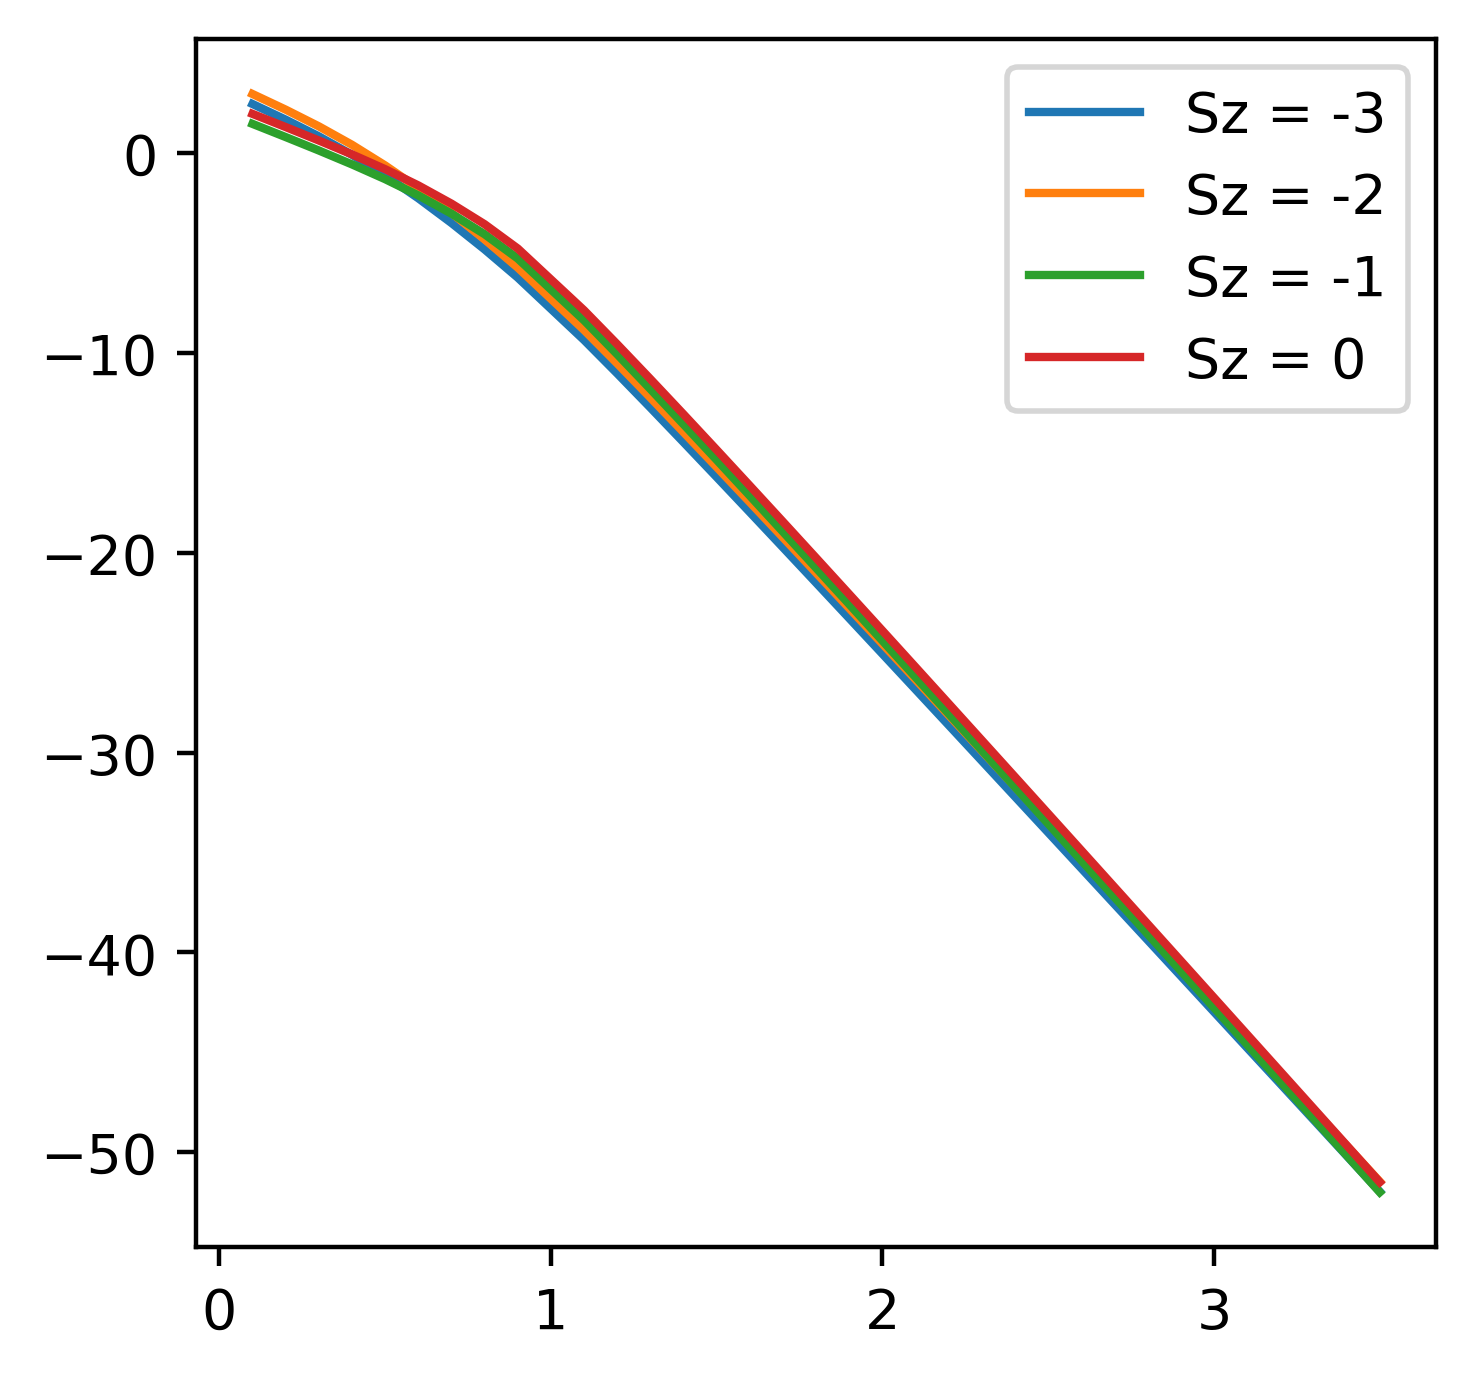

In [7]:
plt.figure(figsize=(4,4), dpi=400)
h = .5
for i, o in enumerate(outputs):
    Sz = Nws[i] - Ne
    print('Total Sz:')
    print(Sz)
    plt.plot(o['G']*np.sum(k), o['energy'] + h*Sz, label='Sz = {}'.format(Sz))
plt.legend()

In [8]:
import seaborn as sns

In [9]:
import pickle
filen = 'pol_results_Ne{}.p'.format(Ne)
pickle.dump(outputs, open(filen, 'wb'))

[-3 -2 -1  0]


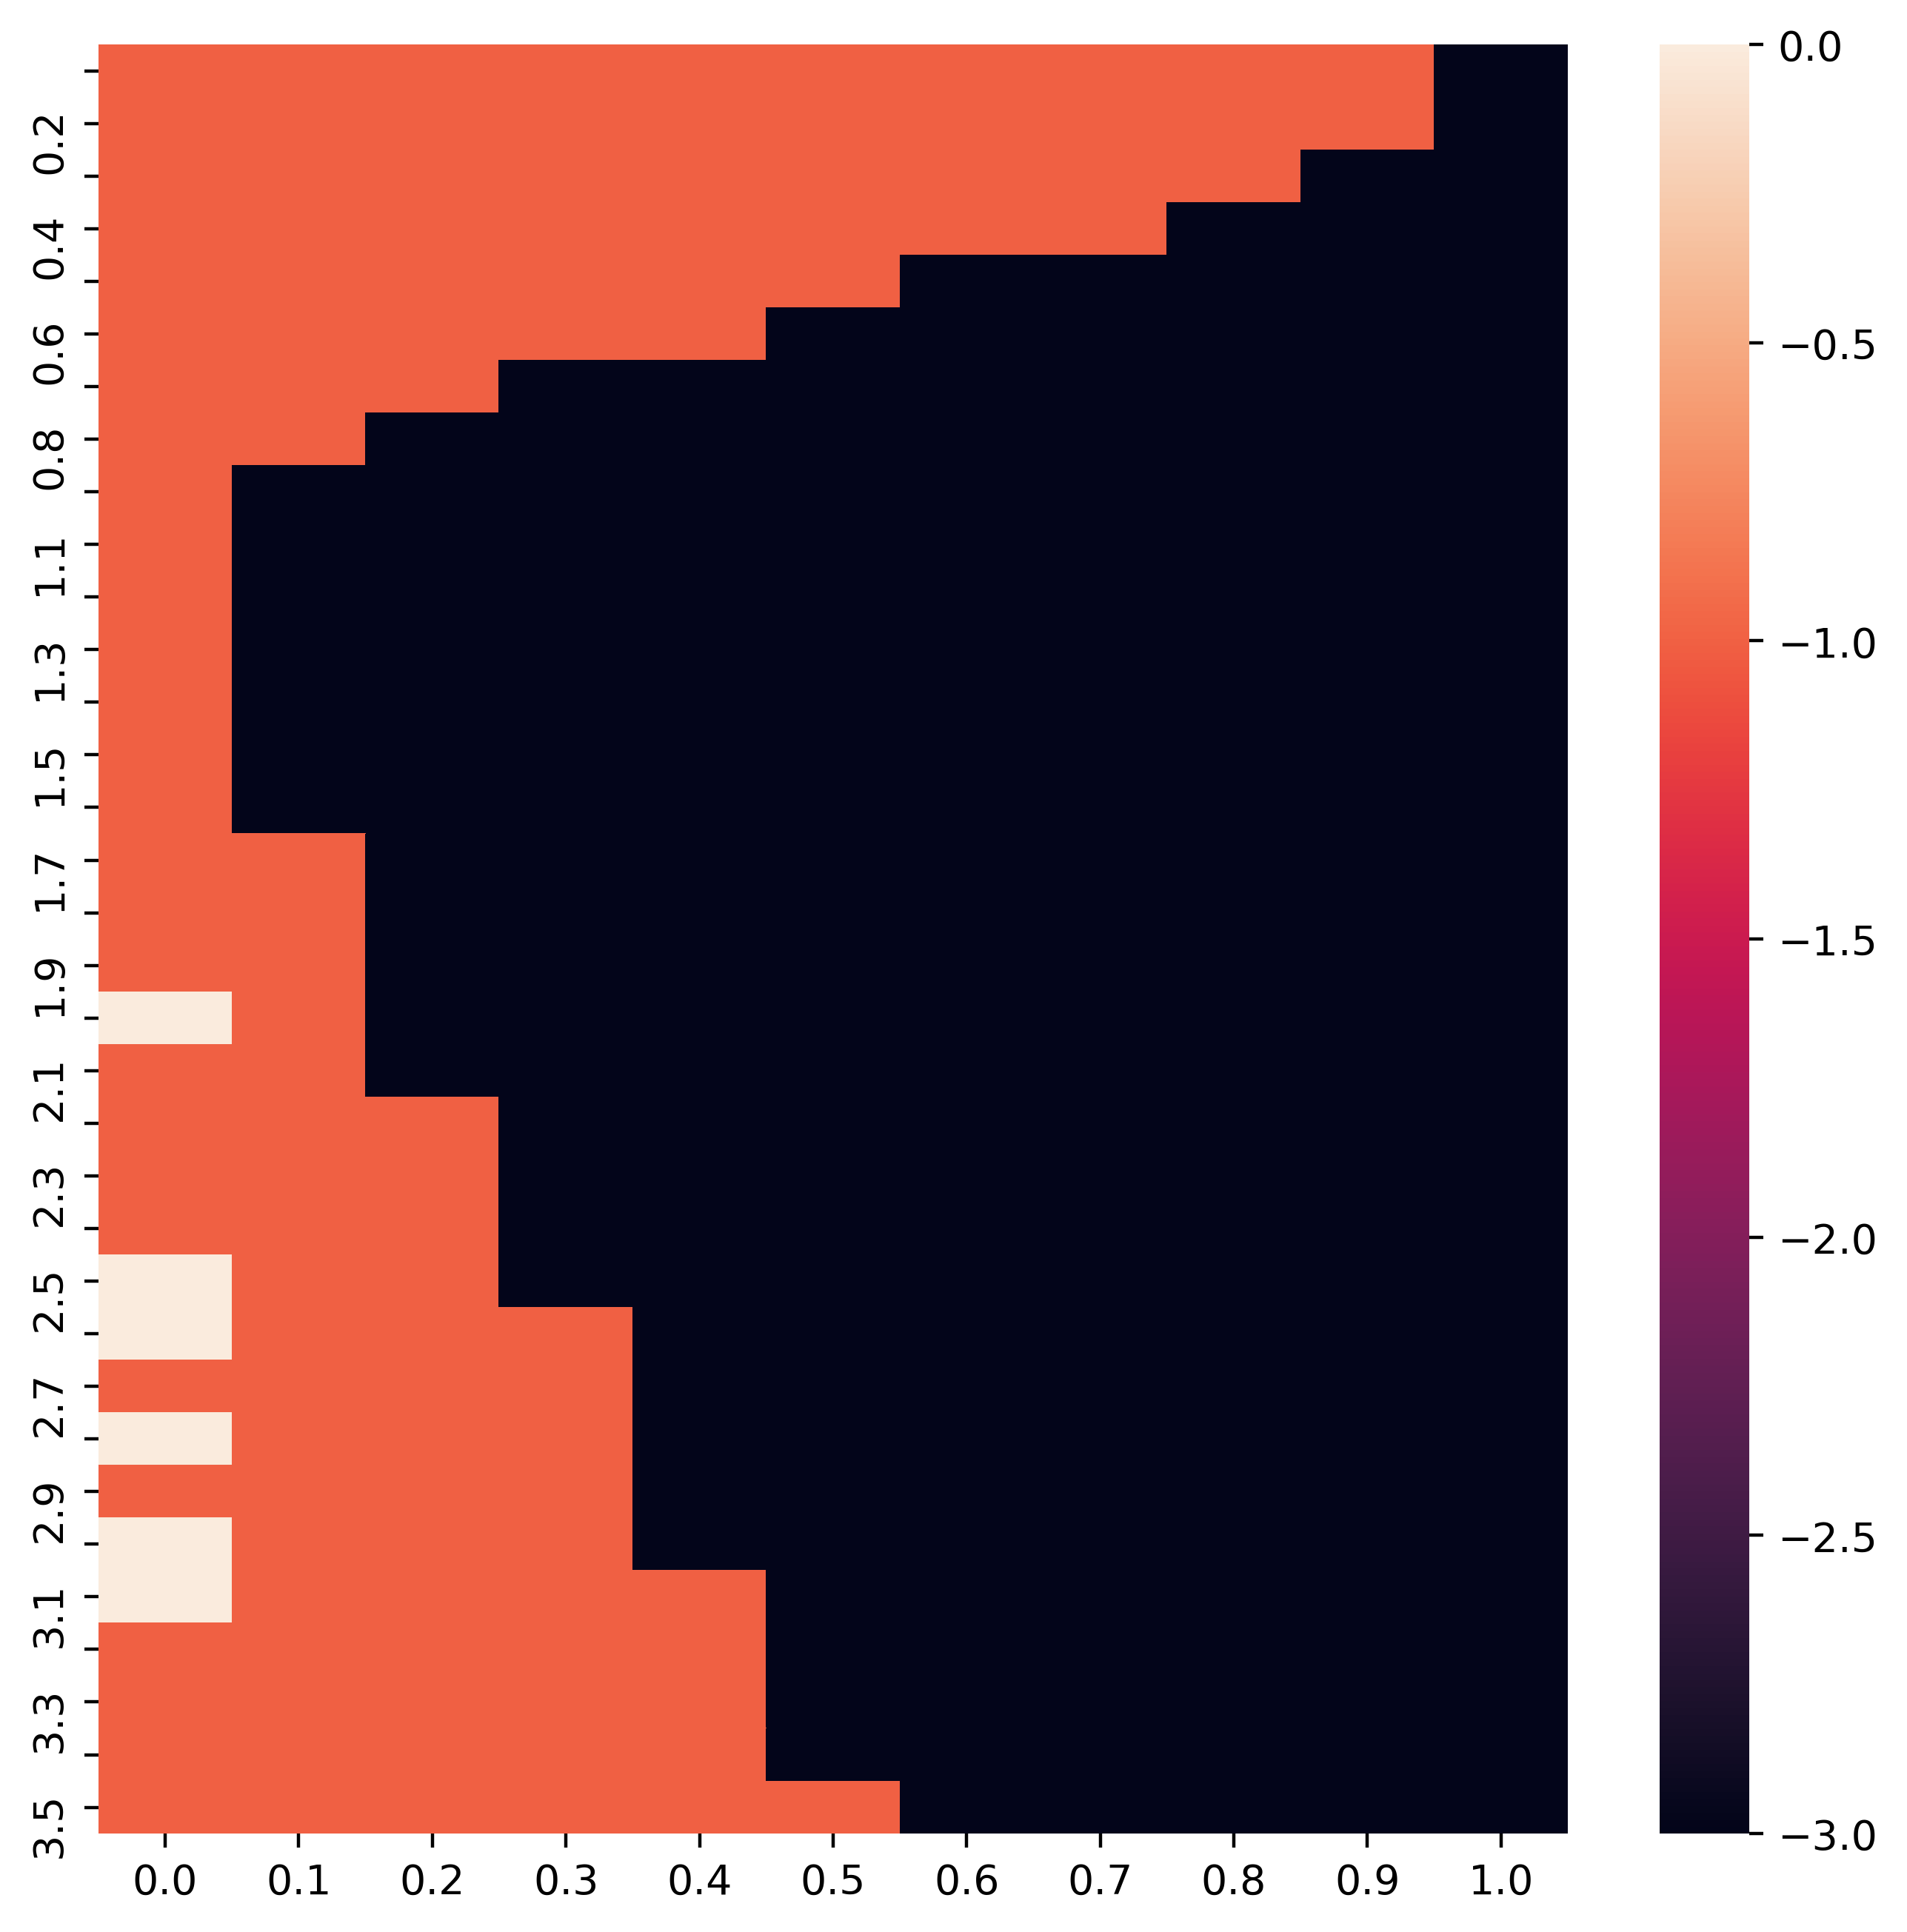

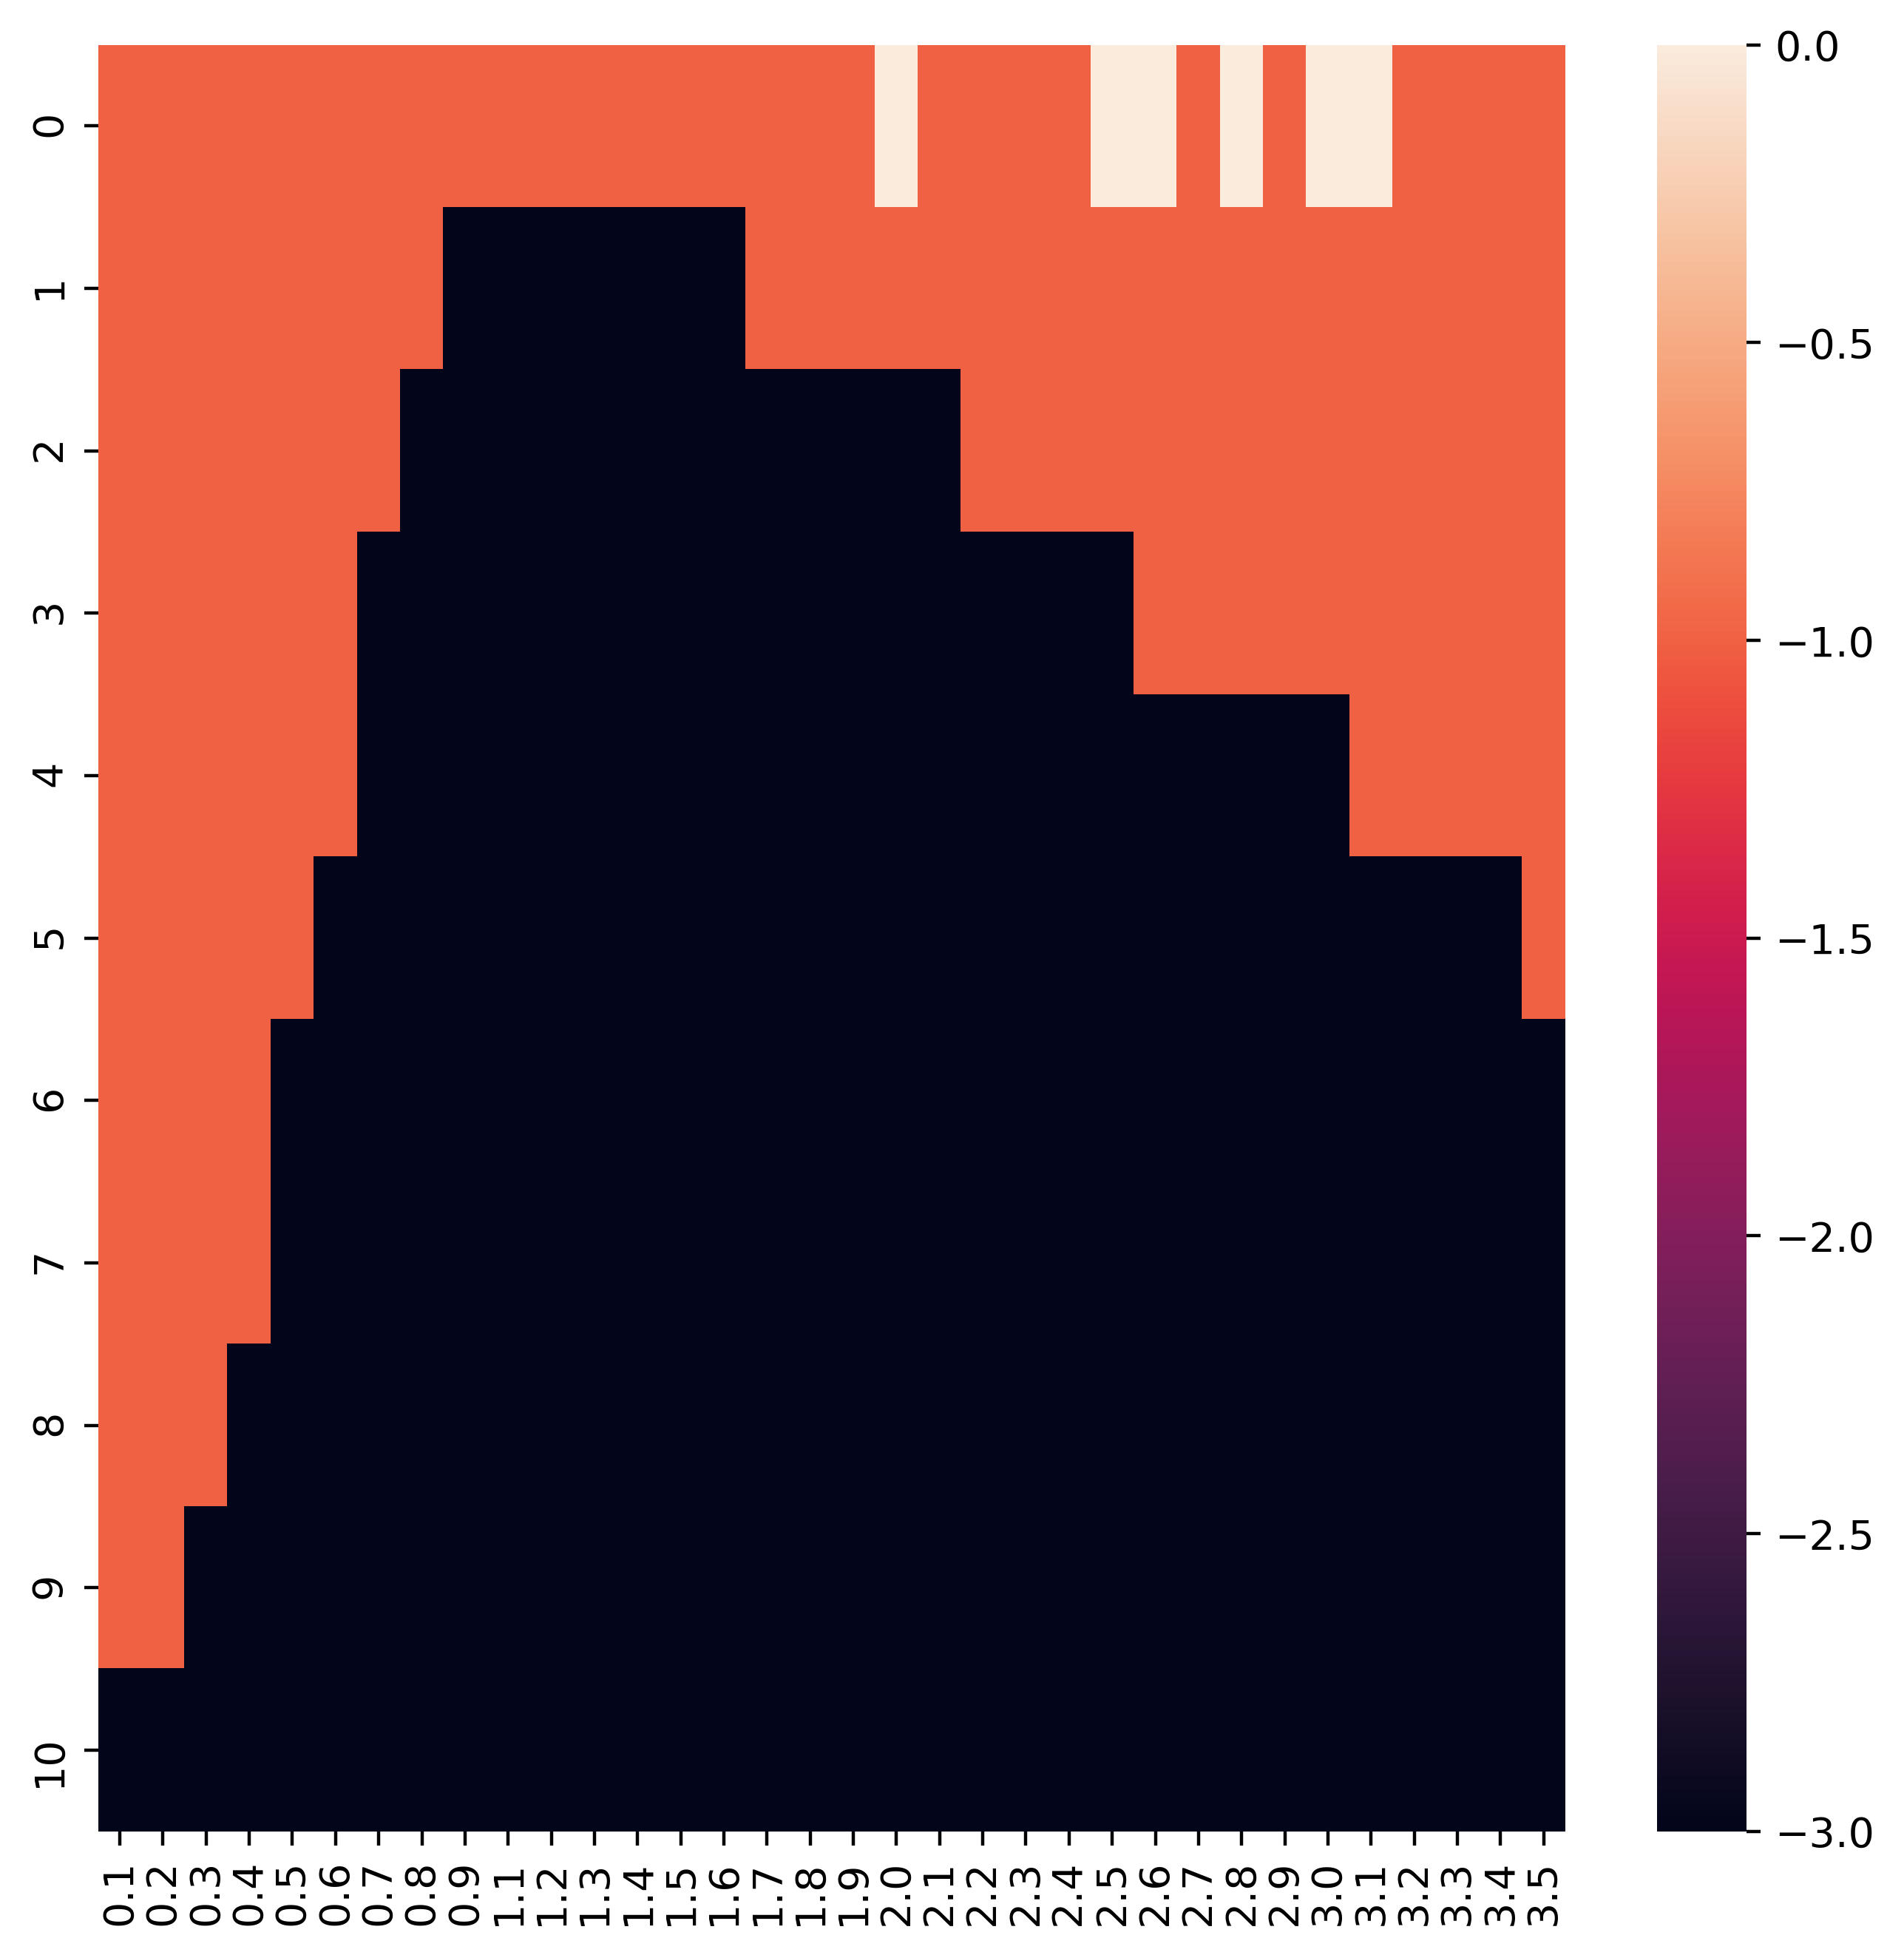

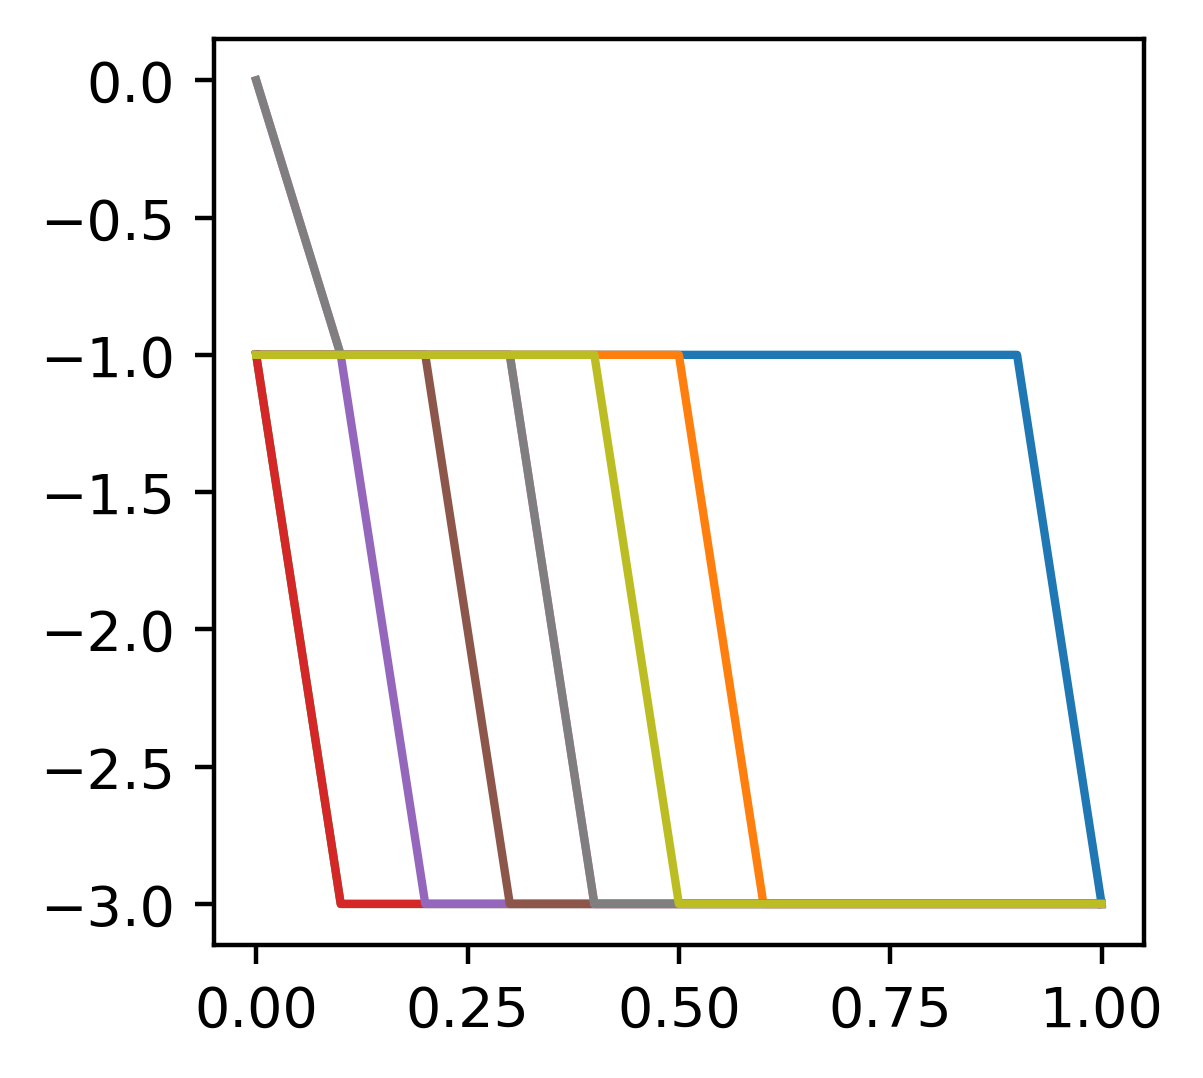

In [10]:
outputs = pickle.load(open(filen, 'rb'))
hs = np.arange(0, 1.1, .1)
Szs = Nws - Ne
print(Szs)
# mags = np.zeros((len(hs), len(outputs[0]['G'])))
mags = pd.DataFrame({})
for n, h in enumerate(hs):
    mags_h = np.zeros(len(outputs[0]['G']))
    for i, G in enumerate(outputs[0]['G']):
        energies = [outputs[j]['energy'].iloc[i] + h * Szs[j] for j in range(len(outputs))]
        min_Ne_ind = np.argmin((energies))
        mags_h[i] = Szs[min_Ne_ind]
    mags[np.round(h, 2)] = mags_h
    
plt.figure(figsize=(8,8), dpi=400)
yticks = [np.round(G*np.sum(k), 1) for G in outputs[0]['G']]
for i in range(len(yticks)):
    if i%2 == 0:
        yticks[i] = None

sns.heatmap(mags, yticklabels=yticks)

# mags = np.zeros((len(hs), len(outputs[0]['G'])))
mags = pd.DataFrame({})
for i, G in enumerate(outputs[0]['G']):
    mags_h = np.zeros(len(hs))
    for j, h in enumerate(hs):
        energies = [outputs[k]['energy'].iloc[i] + h * Szs[k] for k in range(len(outputs))]
        min_Ne_ind = np.argmin((energies))
        mags_h[j] = Szs[min_Ne_ind]
    mags[np.round(G*np.sum(k), 2)] = mags_h
plt.figure(figsize=(8,8), dpi=400)
yticks = np.round(hs, 1)
sns.heatmap(mags), # yticklabels=yticks)

plt.figure(figsize=(3,3), dpi=400)
for i, G in enumerate(mags):
    if i % 4 == 0:
        plt.plot(hs, mags[G], label = r'$G/G_c$= {}'.format(np.round(G, 1)))
# plt.legend()

In [26]:
from exact_diag import spinful_fermion_basis_1d, ham_op_2
from exact_diag import casimir_dict, quantum_operator


In [ ]:
df_ind = 0
G = outputs[0]['G'].iloc[df_ind]
print(G*np.sum(k))
for i, Nw in enumerate(Nws):
    print('')
    Sz = Nw - Ne
    print('Sz')
    print(Sz)
    Nup = int(2*Sz + N)//2
    Ndwn = N - Nup
    print(Nup)
    print(Ndwn)
    basis = spinful_fermion_basis_1d(L, Nf = (Nup, Ndwn))
    H = ham_op_2(l, G, k, basis)
    e, v = H.eigh()
    print('ED energy')
    print(e[0])
    print('ED casimirs')
    for j in range(l):
        c = quantum_operator(casimir_dict(l, j, 1), basis=basis, check_pcon=False, check_herm=False, check_symm=False)
        print(c.matrix_ele(v[:,0], v[:,0]))
    print('RG energy')
    print(outputs[i]['energy'].iloc[df_ind])

0.1

Sz
-3
0
6
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
ED energy
3.9606970367674346
ED casimirs
(3.0000000000000004+0j)
(3.0000000000000004+0j)
(3.0000000000000004+0j)
(3.0000000000000004+0j)
(3.0000000000000004+0j)
(3.0000000000000004+0j)
RG energy
3.9606970367674403

Sz
-2
1
5
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [28]:
df_ind = 3
G = outputs[0]['G'].iloc[df_ind]
print(G*np.sum(k))
for i, Nw in enumerate(Nws):
    print('')
    Sz = Nw - Ne
    print('Sz')
    print(Sz)
    Nup = int(2*Sz + N)//2
    Ndwn = N - Nup
    print(Nup)
    print(Ndwn)
    basis = spinful_fermion_basis_1d(L, Nf = (Nup, Ndwn))
    H = ham_op_2(l, G, k, basis)
    e, v = H.eigh()
    print('ED energies')
    print(e)
    print('ED casimirs')
    for j in range(l):
        c = quantum_operator(casimir_dict(l, j, 1), basis=basis, check_pcon=False, check_herm=False, check_symm=False)
        print(c.matrix_ele(v[:,0], v[:,0]))
    print('RG energy')
    print(outputs[i]['energy'].iloc[df_ind])

0.4

Sz
-3
0
6
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
ED energies
[1.42035117 2.34060686 2.34060686 2.34060686]
ED casimirs
(3.0000000000000044+0j)
(3.0000000000000044+0j)
(3.0000000000000044+0j)
(3.0000000000000044+0j)
(3.0000000000000044+0j)
(3.0000000000000044+0j)
RG energy
1.4203511673929277

Sz
-2
1
5
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
ED energies
[0.94459736 0.94459736 0.94459736 0.94459736]
ED casimirs
(1.5000000000000127+0j)
(3.0000000000000253+0j)
(1.5000000000000127+0j)
(3.0000000000000253+0j)
(3.0000000000000253+0j)
(3.0000000000000253+0j)
RG energy
1.4203511673929277

Sz
-1
2
4
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
ED energies
[-0.06066428  0.45534836  0.45534836  0.45534836]
ED casimirs
(3.0000000000000218-4.336808689942018e-19j)
(3.0000000000000218+0j)
(3.0000000000000218+8.673617379884035e-19j)
(3.0000000000000218+0j)
(3.000000

In [29]:
df_ind = 5
G = outputs[0]['G'].iloc[df_ind]
print(G*np.sum(k))
for i, Nw in enumerate(Nws):
    print('')
    Sz = Nw - Ne
    print('Sz')
    print(Sz)
    Nup = int(2*Sz + N)//2
    Ndwn = N - Nup
    print(Nup)
    print(Ndwn)
    basis = spinful_fermion_basis_1d(L, Nf = (Nup, Ndwn))
    H = ham_op_2(l, G, k, basis)
    e, v = H.eigh()
    print('ED energies')
    print(e)
    print('ED casimirs')
    for j in range(l):
        c = quantum_operator(casimir_dict(l, j, 1), basis=basis, check_pcon=False, check_herm=False, check_symm=False)
        print(c.matrix_ele(v[:,0], v[:,0]))
    print('RG energy')
    print(outputs[i]['energy'].iloc[df_ind])

0.5999999999999999

Sz
-3
0
6
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
ED energies
[-0.75440281  0.45779468  0.51761731  0.51761731]
ED casimirs
(3.000000000000006+0j)
(3.000000000000006+0j)
(3.000000000000006+0j)
(3.000000000000006+0j)
(3.000000000000006+0j)
(3.000000000000006+0j)
RG energy
-0.7544028055118801

Sz
-2
1
5
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
ED energies
[-0.75440281 -0.71578755 -0.61603548 -0.71578755]
ED casimirs
(2.9999999999999973-5.551115123125783e-17j)
(2.9999999999999973-5.551115123125783e-17j)
(2.9999999999999973+0j)
(2.9999999999999973-5.551115123125783e-17j)
(2.9999999999999973+0j)
(2.9999999999999973+5.551115123125783e-17j)
RG energy
-0.7544028055118801

Sz
-1
2
4
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
ED energies
[-1.61252899 -1.09810292 -1.09810292 -1.09810292]
ED casimirs
(3.0000000000000213+0j)
(3.0000000000000213+0j

In [30]:
df_ind = -1
G = outputs[0]['G'].iloc[df_ind]
print(G*np.sum(k))
for i, Nw in enumerate(Nws):
    print('')
    Sz = Nw - Ne
    print('Sz')
    print(Sz)
    Nup = int(2*Sz + N)//2
    Ndwn = N - Nup
    print(Nup)
    print(Ndwn)
    basis = spinful_fermion_basis_1d(L, Nf = (Nup, Ndwn))
    H = ham_op_2(l, G, k, basis)
    e, v = H.eigh()
    print('ED energies')
    print(e)
    print('ED casimirs')
    for j in range(l):
        c = quantum_operator(casimir_dict(l, j, 1), basis=basis, check_pcon=False, check_herm=False, check_symm=False)
        print(c.matrix_ele(v[:,0], v[:,0]))
    print('RG energy')
    print(outputs[i]['energy'].iloc[df_ind])

3.5000000000000004

Sz
-3
0
6
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
ED energies
[-50.46728171 -43.17904653 -42.78114587 -42.78114587]
ED casimirs
(3.000000000000003+0j)
(3.000000000000003+0j)
(3.000000000000003+0j)
(3.000000000000003+0j)
(3.000000000000003+0j)
(3.000000000000003+0j)
RG energy
-50.46728171134515

Sz
-2
1
5
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
ED energies
[-50.46728171 -43.17904653 -42.78114587 -42.78114587]
ED casimirs
(3.000000000000008+0j)
(3.000000000000008+0j)
(3.000000000000008+0j)
(3.000000000000008+0j)
(3.000000000000008+1.1102230246251565e-16j)
(3.000000000000008+0j)
RG energy
-50.467281711345144

Sz
-1
2
4
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
ED energies
[-51.49594709 -50.46728171 -43.17904653 -42.78114587]
ED casimirs
(3.0000000000000098+2.7755575615628914e-17j)
(3.0000000000000098+2.7755575615628914e-17j)
(3.0000000